# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

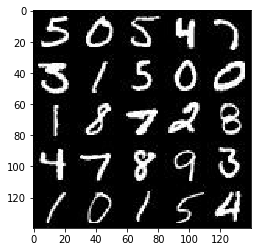

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

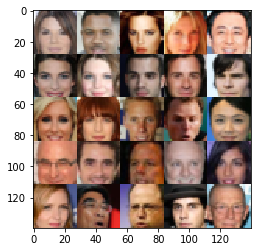

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 3x3x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 3*3*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512 now
        
        x1_5 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='valid')
        x1_5 = tf.layers.batch_normalization(x1_5, training=is_train)
        x1_5 = tf.maximum(alpha * x1_5, x1_5)
        # 7x7x256now
       
        x2 = tf.layers.conv2d_transpose(x1_5, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        out = tf.tanh(logits)
        
        return out
    
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    print("data ",data_shape, data_image_mode)
    
    losses = []
    steps = 0
    
    
    input_real, input_z, input_learning_rate = model_inputs(
        data_shape[1],data_shape[2],data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_learning_rate:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 6*12, input_z, data_shape[3],data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data  (60000, 28, 28, 1) L
Epoch 1/2... Discriminator Loss: 1.9158... Generator Loss: 0.3082
Epoch 1/2... Discriminator Loss: 0.8080... Generator Loss: 1.2976
Epoch 1/2... Discriminator Loss: 0.5894... Generator Loss: 1.8882
Epoch 1/2... Discriminator Loss: 1.0335... Generator Loss: 1.0766
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.5925
Epoch 1/2... Discriminator Loss: 0.9752... Generator Loss: 1.1042
Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 1.7560
Epoch 1/2... Discriminator Loss: 0.8082... Generator Loss: 1.4788
Epoch 1/2... Discriminator Loss: 0.6426... Generator Loss: 2.0610
Epoch 1/2... Discriminator Loss: 0.6740... Generator Loss: 1.9070


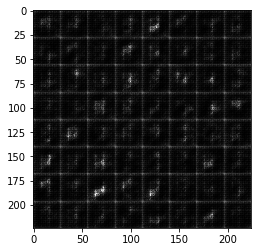

Epoch 1/2... Discriminator Loss: 0.8470... Generator Loss: 1.2081
Epoch 1/2... Discriminator Loss: 1.2751... Generator Loss: 0.6112
Epoch 1/2... Discriminator Loss: 1.1587... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 0.9828... Generator Loss: 0.9728
Epoch 1/2... Discriminator Loss: 0.9067... Generator Loss: 1.5326
Epoch 1/2... Discriminator Loss: 1.2204... Generator Loss: 1.7689
Epoch 1/2... Discriminator Loss: 1.1255... Generator Loss: 1.0866
Epoch 1/2... Discriminator Loss: 1.0495... Generator Loss: 0.9865
Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 1.2048
Epoch 1/2... Discriminator Loss: 0.9422... Generator Loss: 1.1701


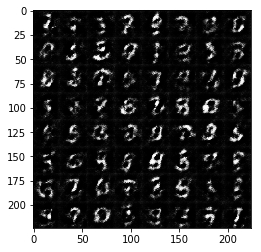

Epoch 1/2... Discriminator Loss: 1.1008... Generator Loss: 0.8655
Epoch 1/2... Discriminator Loss: 1.0461... Generator Loss: 1.6156
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 1.6296
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 1.5918
Epoch 1/2... Discriminator Loss: 1.0434... Generator Loss: 0.9092
Epoch 1/2... Discriminator Loss: 0.9634... Generator Loss: 1.0635
Epoch 1/2... Discriminator Loss: 1.0561... Generator Loss: 0.7891
Epoch 1/2... Discriminator Loss: 1.0352... Generator Loss: 0.8237
Epoch 1/2... Discriminator Loss: 0.9272... Generator Loss: 1.5238
Epoch 1/2... Discriminator Loss: 0.8841... Generator Loss: 1.2081


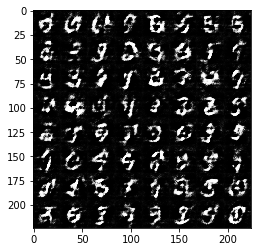

Epoch 1/2... Discriminator Loss: 0.9490... Generator Loss: 1.0798
Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 0.7287
Epoch 1/2... Discriminator Loss: 0.8941... Generator Loss: 1.1602
Epoch 1/2... Discriminator Loss: 0.9987... Generator Loss: 0.9153
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 1.1780
Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 0.8668
Epoch 1/2... Discriminator Loss: 0.8594... Generator Loss: 1.1926
Epoch 1/2... Discriminator Loss: 0.8905... Generator Loss: 1.7496
Epoch 1/2... Discriminator Loss: 0.8773... Generator Loss: 1.7332
Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 1.5219


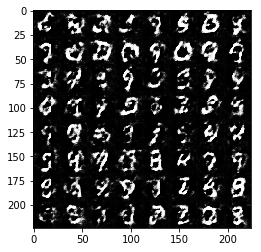

Epoch 1/2... Discriminator Loss: 1.0739... Generator Loss: 2.3411
Epoch 1/2... Discriminator Loss: 1.2288... Generator Loss: 0.6019
Epoch 1/2... Discriminator Loss: 0.7620... Generator Loss: 1.3588
Epoch 1/2... Discriminator Loss: 0.9302... Generator Loss: 0.9805
Epoch 1/2... Discriminator Loss: 0.8212... Generator Loss: 1.2837
Epoch 1/2... Discriminator Loss: 0.9960... Generator Loss: 0.9424
Epoch 1/2... Discriminator Loss: 0.9375... Generator Loss: 1.4782
Epoch 1/2... Discriminator Loss: 0.8189... Generator Loss: 1.6188
Epoch 1/2... Discriminator Loss: 0.8991... Generator Loss: 2.0341
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 0.7291


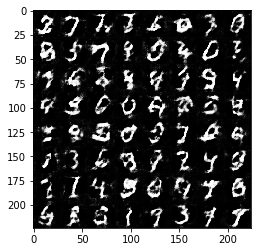

Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 0.8036
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.5080
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 0.8807
Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 1.0192
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 0.8347
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 1.9238
Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 1.4620
Epoch 1/2... Discriminator Loss: 0.9622... Generator Loss: 0.9226
Epoch 1/2... Discriminator Loss: 1.0457... Generator Loss: 2.0165
Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 1.2518


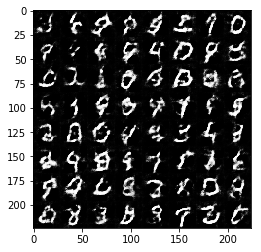

Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 0.7382
Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 1.1705
Epoch 1/2... Discriminator Loss: 1.0534... Generator Loss: 1.0264
Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 1.2367
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 1.0758... Generator Loss: 0.7813
Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 1.0733
Epoch 1/2... Discriminator Loss: 1.1548... Generator Loss: 2.0668
Epoch 1/2... Discriminator Loss: 0.9121... Generator Loss: 1.2774
Epoch 1/2... Discriminator Loss: 1.2847... Generator Loss: 0.5558


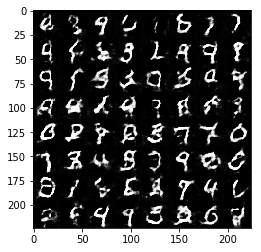

Epoch 1/2... Discriminator Loss: 0.9365... Generator Loss: 1.0539
Epoch 1/2... Discriminator Loss: 0.8895... Generator Loss: 1.6368
Epoch 1/2... Discriminator Loss: 0.8960... Generator Loss: 1.0519
Epoch 1/2... Discriminator Loss: 1.4061... Generator Loss: 0.5176
Epoch 1/2... Discriminator Loss: 0.9438... Generator Loss: 1.0690
Epoch 1/2... Discriminator Loss: 0.9011... Generator Loss: 1.2909
Epoch 1/2... Discriminator Loss: 1.0262... Generator Loss: 1.4765
Epoch 1/2... Discriminator Loss: 0.9719... Generator Loss: 0.9354
Epoch 1/2... Discriminator Loss: 0.8807... Generator Loss: 1.2153
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 0.9861


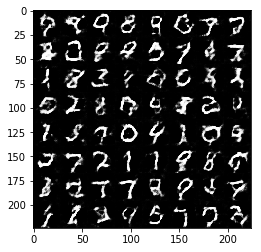

Epoch 1/2... Discriminator Loss: 0.9951... Generator Loss: 1.5654
Epoch 1/2... Discriminator Loss: 0.9171... Generator Loss: 1.9540
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 0.8164
Epoch 1/2... Discriminator Loss: 1.3415... Generator Loss: 0.5322
Epoch 1/2... Discriminator Loss: 0.9526... Generator Loss: 1.3663
Epoch 1/2... Discriminator Loss: 1.0609... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 0.9139... Generator Loss: 1.1647
Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 1.1584
Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 1.6746
Epoch 1/2... Discriminator Loss: 0.8940... Generator Loss: 1.4124


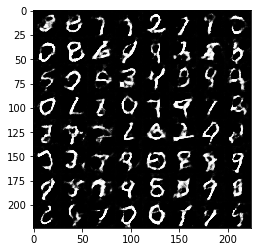

Epoch 1/2... Discriminator Loss: 0.8724... Generator Loss: 1.1405
Epoch 1/2... Discriminator Loss: 1.1370... Generator Loss: 0.7032
Epoch 1/2... Discriminator Loss: 0.8355... Generator Loss: 1.2498
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 1.8129
Epoch 2/2... Discriminator Loss: 1.0525... Generator Loss: 0.7826
Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 1.0421
Epoch 2/2... Discriminator Loss: 1.0818... Generator Loss: 1.8514
Epoch 2/2... Discriminator Loss: 0.9032... Generator Loss: 1.6176
Epoch 2/2... Discriminator Loss: 0.8763... Generator Loss: 1.2360
Epoch 2/2... Discriminator Loss: 1.0622... Generator Loss: 0.8763


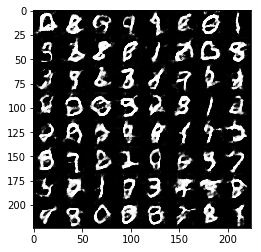

Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 1.8083
Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.3405
Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 1.1582
Epoch 2/2... Discriminator Loss: 1.5221... Generator Loss: 2.8385
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 1.2456
Epoch 2/2... Discriminator Loss: 0.9740... Generator Loss: 0.8680
Epoch 2/2... Discriminator Loss: 1.0304... Generator Loss: 0.8731
Epoch 2/2... Discriminator Loss: 0.8090... Generator Loss: 1.2143
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.1073
Epoch 2/2... Discriminator Loss: 0.9669... Generator Loss: 0.8735


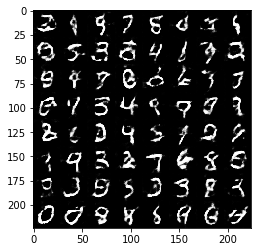

Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 1.1415
Epoch 2/2... Discriminator Loss: 0.8899... Generator Loss: 1.1693
Epoch 2/2... Discriminator Loss: 0.9241... Generator Loss: 0.9195
Epoch 2/2... Discriminator Loss: 0.7243... Generator Loss: 1.7091
Epoch 2/2... Discriminator Loss: 1.4466... Generator Loss: 3.6248
Epoch 2/2... Discriminator Loss: 0.7327... Generator Loss: 1.4668
Epoch 2/2... Discriminator Loss: 0.7925... Generator Loss: 1.2177
Epoch 2/2... Discriminator Loss: 0.7322... Generator Loss: 1.4477
Epoch 2/2... Discriminator Loss: 1.2526... Generator Loss: 2.9745
Epoch 2/2... Discriminator Loss: 0.7648... Generator Loss: 1.7170


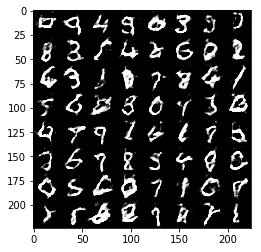

Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.4116
Epoch 2/2... Discriminator Loss: 0.8076... Generator Loss: 1.1131
Epoch 2/2... Discriminator Loss: 0.8943... Generator Loss: 1.0253
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 1.0799
Epoch 2/2... Discriminator Loss: 0.8371... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 2.3072... Generator Loss: 3.7175
Epoch 2/2... Discriminator Loss: 1.2124... Generator Loss: 0.8508
Epoch 2/2... Discriminator Loss: 1.3001... Generator Loss: 0.6773
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 1.1274
Epoch 2/2... Discriminator Loss: 0.9739... Generator Loss: 0.8983


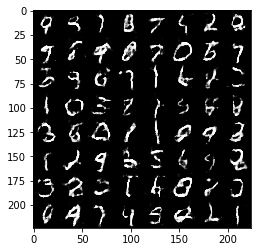

Epoch 2/2... Discriminator Loss: 0.7494... Generator Loss: 1.6794
Epoch 2/2... Discriminator Loss: 0.8746... Generator Loss: 1.2858
Epoch 2/2... Discriminator Loss: 1.0353... Generator Loss: 0.7925
Epoch 2/2... Discriminator Loss: 0.8671... Generator Loss: 1.2289
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 1.0301
Epoch 2/2... Discriminator Loss: 0.8072... Generator Loss: 1.3034
Epoch 2/2... Discriminator Loss: 0.8435... Generator Loss: 1.4521
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 1.2315
Epoch 2/2... Discriminator Loss: 0.7527... Generator Loss: 1.8055
Epoch 2/2... Discriminator Loss: 0.7953... Generator Loss: 1.3059


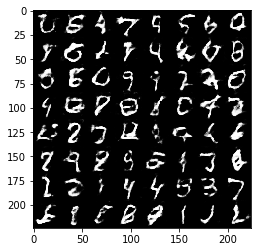

Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 0.9970
Epoch 2/2... Discriminator Loss: 0.9048... Generator Loss: 1.0626
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 1.0354
Epoch 2/2... Discriminator Loss: 1.5167... Generator Loss: 2.6924
Epoch 2/2... Discriminator Loss: 0.7695... Generator Loss: 1.6706
Epoch 2/2... Discriminator Loss: 0.9025... Generator Loss: 1.0332
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 1.9005
Epoch 2/2... Discriminator Loss: 0.8255... Generator Loss: 1.3648
Epoch 2/2... Discriminator Loss: 0.9677... Generator Loss: 0.9148
Epoch 2/2... Discriminator Loss: 1.1292... Generator Loss: 0.7584


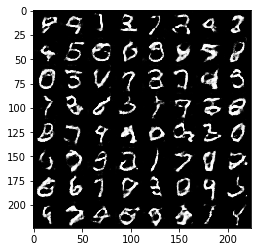

Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 1.2116
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 1.1364
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 1.2575
Epoch 2/2... Discriminator Loss: 1.0036... Generator Loss: 1.1269
Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 1.1334
Epoch 2/2... Discriminator Loss: 0.8813... Generator Loss: 1.0609
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 0.9504
Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 2.3644
Epoch 2/2... Discriminator Loss: 0.8418... Generator Loss: 1.1956


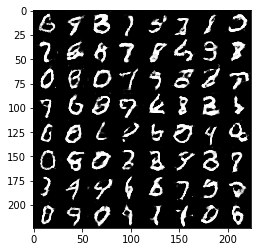

Epoch 2/2... Discriminator Loss: 0.8205... Generator Loss: 1.2666
Epoch 2/2... Discriminator Loss: 1.0718... Generator Loss: 0.7673
Epoch 2/2... Discriminator Loss: 1.0643... Generator Loss: 0.9176
Epoch 2/2... Discriminator Loss: 0.8601... Generator Loss: 1.2171
Epoch 2/2... Discriminator Loss: 0.9151... Generator Loss: 0.9996
Epoch 2/2... Discriminator Loss: 0.7616... Generator Loss: 1.4578
Epoch 2/2... Discriminator Loss: 0.7998... Generator Loss: 1.2864
Epoch 2/2... Discriminator Loss: 1.0550... Generator Loss: 2.2057
Epoch 2/2... Discriminator Loss: 0.8673... Generator Loss: 1.0913
Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 1.8825


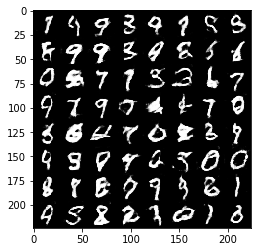

Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 1.5024
Epoch 2/2... Discriminator Loss: 1.0179... Generator Loss: 0.9049
Epoch 2/2... Discriminator Loss: 0.8981... Generator Loss: 0.9944
Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 1.0550
Epoch 2/2... Discriminator Loss: 0.6937... Generator Loss: 1.6435
Epoch 2/2... Discriminator Loss: 0.7783... Generator Loss: 1.2857
Epoch 2/2... Discriminator Loss: 0.8757... Generator Loss: 1.0098
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.6426
Epoch 2/2... Discriminator Loss: 1.0249... Generator Loss: 0.8520
Epoch 2/2... Discriminator Loss: 0.6915... Generator Loss: 1.9715


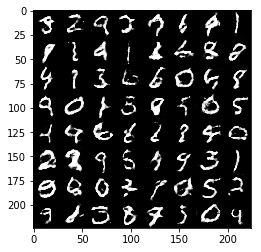

Epoch 2/2... Discriminator Loss: 0.9521... Generator Loss: 0.9408
Epoch 2/2... Discriminator Loss: 0.9511... Generator Loss: 1.7846
Epoch 2/2... Discriminator Loss: 1.1856... Generator Loss: 2.3474
Epoch 2/2... Discriminator Loss: 1.0843... Generator Loss: 0.9336
Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 0.9080
Epoch 2/2... Discriminator Loss: 0.8528... Generator Loss: 1.1685
Epoch 2/2... Discriminator Loss: 0.8074... Generator Loss: 1.4661


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data  (202599, 28, 28, 3) RGB
Epoch 1/1... Discriminator Loss: 1.9306... Generator Loss: 0.3148
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 1.2654
Epoch 1/1... Discriminator Loss: 0.6851... Generator Loss: 1.7361
Epoch 1/1... Discriminator Loss: 0.5498... Generator Loss: 2.0152
Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 2.0213
Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 2.1818
Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 2.2724
Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 4.0161
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.9629


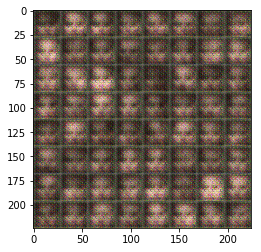

Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 2.2406
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.4937
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 2.5105
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.6773
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 2.9292
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.2928
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.8759
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 2.2551
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.3771


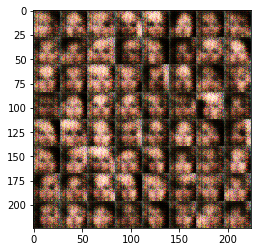

Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 1.8643
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.2668
Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 2.1449
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.4045
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.8667
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.3931
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.8248


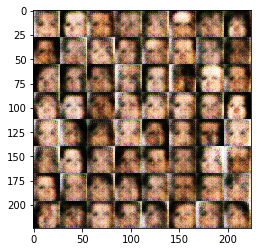

Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 1.2110
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.5135
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 1.2382
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.2901
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 1.8626
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.4303
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 2.0300
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 1.2420


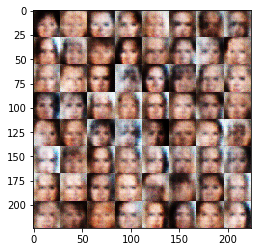

Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.6164
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.2794
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 2.2085
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.4299
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 1.7210
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 1.4460


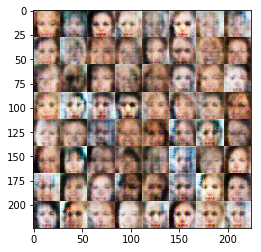

Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.8649
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.3800
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 2.1722
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.4482
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.6512
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 1.4946


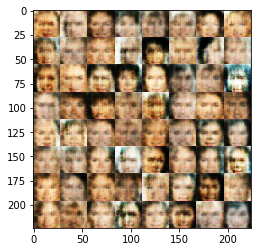

Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 1.1670
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.4679
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.8973


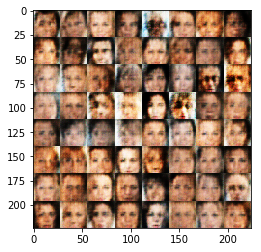

Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 1.6659
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.1299
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 1.1947
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 1.1924
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.5817


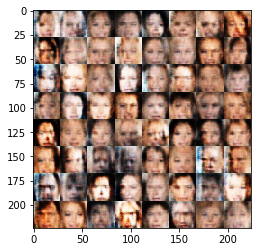

Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.3246
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.9653


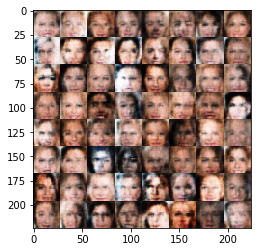

Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 1.4569
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 1.1424


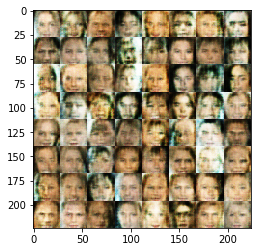

Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.1277
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.2212
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 1.1807


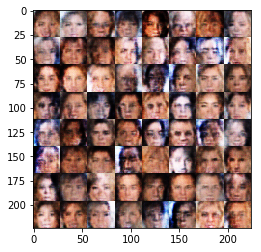

Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.2712
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.0251


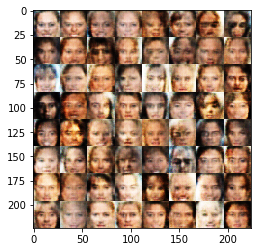

Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.4800
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.2527
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.4394
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.7158


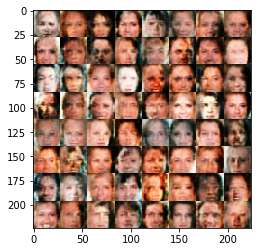

Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 1.2805
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.9763


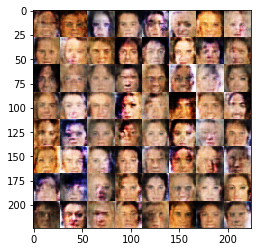

Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 1.1224
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 1.2435
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.1428


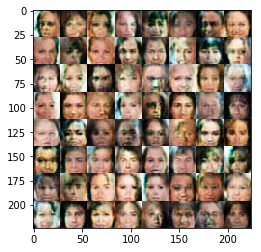

Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 1.1867
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.8494
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.1825


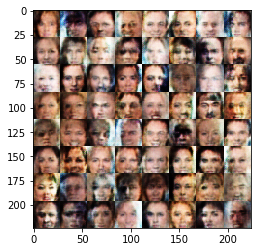

Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 1.3291
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 1.7207
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 1.5361
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.8065


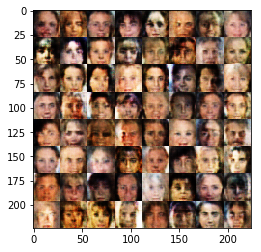

Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.2554
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 1.2445
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 1.3479
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 1.1032


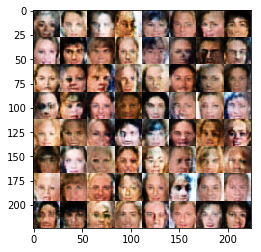

Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.4901
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 1.2133
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.4470
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.8704


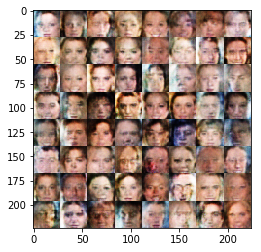

Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.1983
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 1.9064
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.9193


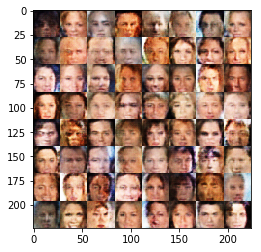

Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 1.1844
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.3651
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.7123


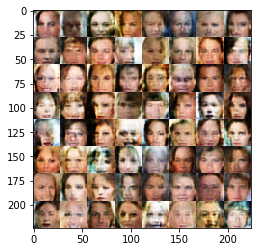

Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 1.1967
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.9792


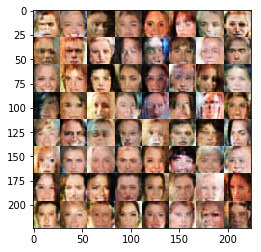

Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 1.3474
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.3449
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.5706


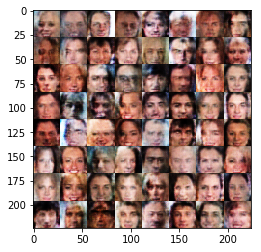

Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 1.2688
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 1.3851


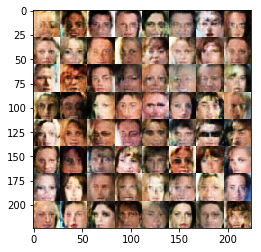

Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.3151
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8829


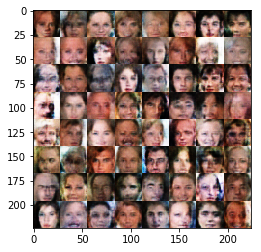

Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 1.1256
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 1.1678
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 1.7944
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 1.1542
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 1.0835


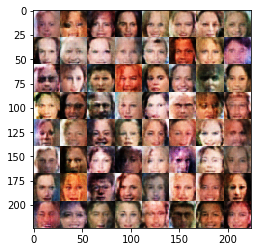

Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.3407
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 1.2672


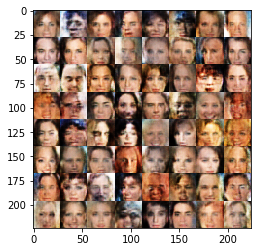

Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.5354
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 1.3124
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.9888


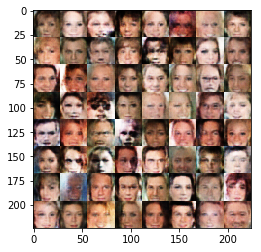

Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.3196
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 1.6653
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 1.3366
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.2259
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 1.5809


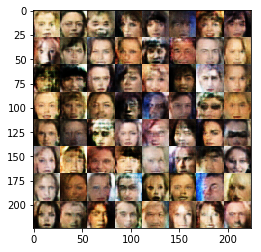

Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.3697
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.5483


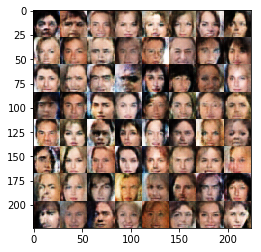

Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 1.2778
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.4135
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.3219
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.7922


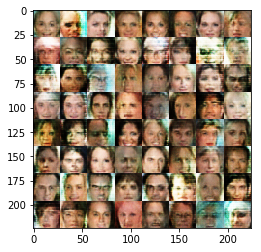

Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.8871


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.